## Loading and MainCode

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from unet_model import UNet  # Import your model


In [2]:
class SubsetInferenceDataset(Dataset):
    def __init__(self, batch_dir, transform=None, max_slices=1000):
        self.batch_dir = batch_dir
        self.batch_files = sorted([os.path.join(batch_dir, f) for f in os.listdir(batch_dir) if f.endswith('.npz')])
        self.transform = transform
        self.images = []
        slice_counter = 0

        for batch_file in self.batch_files:
            batch = np.load(batch_file)['images']
            for i in range(batch.shape[0]):
                if slice_counter >= max_slices:
                    break
                self.images.append(batch[i])
                slice_counter += 1
            if slice_counter >= max_slices:
                break

        print(f"✅ Loaded {len(self.images)} slices for test inference.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.squeeze(img)
        img = Image.fromarray(img).convert("L")
        if self.transform:
            img = self.transform(img)
        return img


In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

batch_dir = "../dataset/volumes_modified/merge_temp"  # Your batch folder
dataset = SubsetInferenceDataset(batch_dir, transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=False)  # Batch size 4 for faster inference


✅ Loaded 1000 slices for test inference.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔌 Using device: {device}")

model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("../models/unet_batch_epoch_1.pth", map_location=device))
model.eval()


🔌 Using device: cuda


UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [5]:
import numpy as np

preds = np.load("../dataset/volumes_modified/unet_predictions.npy")
print(f"✅ Loaded predictions shape: {preds.shape}")


✅ Loaded predictions shape: (2500, 1, 256, 256)


✅ Loaded predictions shape: (2500, 1, 256, 256)


c:\Users\vighn\anaconda3\envs\lunaenv-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


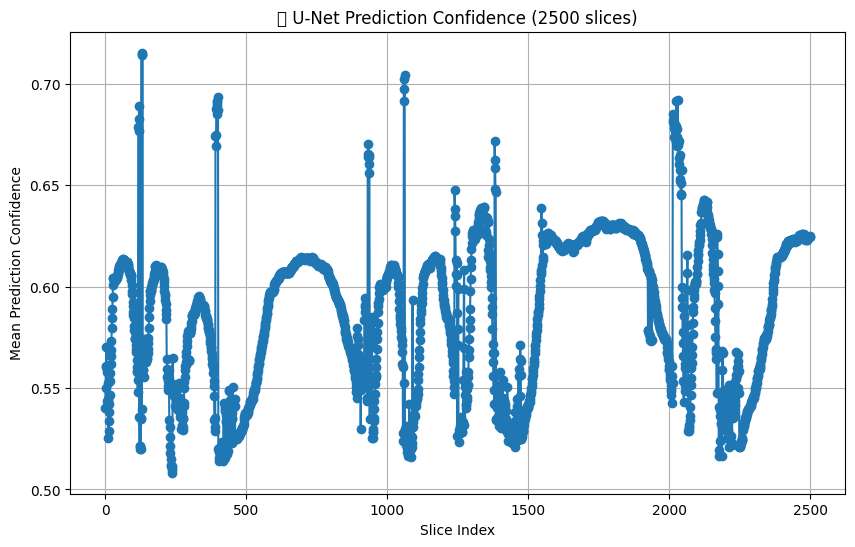

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Load predictions
preds = np.load("../dataset/volumes_modified/unet_predictions.npy")
print(f"✅ Loaded predictions shape: {preds.shape}")

# Calculate mean confidence
mean_confidences = [pred.mean() for pred in preds]

# Plot
plt.figure(figsize=(10,6))
plt.plot(mean_confidences, marker='o')
plt.xlabel("Slice Index")
plt.ylabel("Mean Prediction Confidence")
plt.title("📈 U-Net Prediction Confidence (2500 slices)")
plt.grid(True)
plt.show()


✅ Loaded predictions shape: (2500, 1, 256, 256)


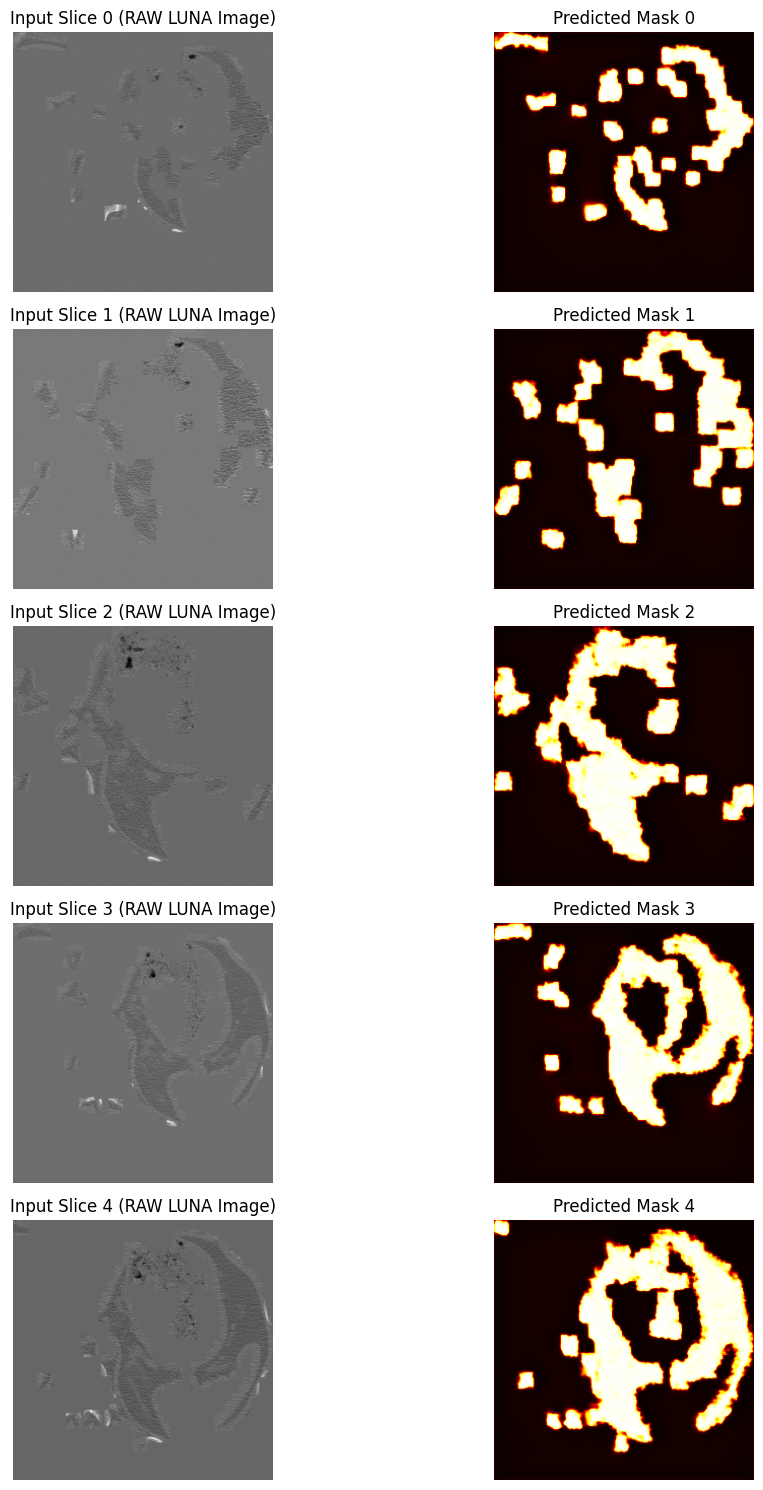

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Load predictions
preds = np.load("../dataset/volumes_modified/unet_predictions.npy")
print(f"✅ Loaded predictions shape: {preds.shape}")

# Load corresponding input slices
input_dir = "../dataset/volumes_modified/merge_temp"
input_slices = []

slice_counter = 0
for batch_file in sorted(os.listdir(input_dir)):
    if batch_file.endswith('.npz'):
        batch = np.load(os.path.join(input_dir, batch_file))['images']
        for i in range(batch.shape[0]):
            if slice_counter >= 2500:
                break
            input_slices.append(batch[i])
            slice_counter += 1
        if slice_counter >= 2500:
            break

# 🔥 Plot 5 examples RAW
num_examples = 5
plt.figure(figsize=(12, num_examples * 3))

for idx in range(num_examples):
    input_img = np.squeeze(input_slices[idx])

    # Input slice (PURE RAW)
    plt.subplot(num_examples, 2, idx*2 + 1)
    plt.imshow(input_img, cmap='gray')  # No normalization
    plt.title(f"Input Slice {idx} (RAW LUNA Image)")
    plt.axis('off')

    # Predicted mask (hot colormap)
    plt.subplot(num_examples, 2, idx*2 + 2)
    plt.imshow(np.squeeze(preds[idx][0]), cmap='hot')
    plt.title(f"Predicted Mask {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## TESTING and VALIDATION

In [11]:
!pip install SimpleITK

import SimpleITK as sitk
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from unet_model import UNet  # Make sure you can import your model


In [ ]:
# Path to your mhd file
mhd_path = "../your_mhd_folder/your_scan.mhd"  # CHANGE THIS

# Load using SimpleITK
img_itk = sitk.ReadImage(mhd_path)
img_np = sitk.GetArrayFromImage(img_itk)  # shape: (Slices, H, W)

print(f"✅ Loaded CT Scan: {img_np.shape} (Slices, Height, Width)")


In [14]:
class TestImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])  # 🔥 Look for PNGs
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("L")  # 🔥 Open as grayscale

        if self.transform:
            img = self.transform(img)

        return img


In [15]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Paths
test_images_dir = r"C:\Users\vighn\OneDrive\Desktop\BME-515 Project\Luna16Project\dataset\prepared_data\test\images"

dataset = TestImageDataset(test_images_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

print(f"✅ Found {len(dataset)} test images.")


✅ Found 77 test images.


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔌 Using device: {device}")

model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("../models/unet_batch_epoch_2.pth", map_location=device))
model.eval()


🔌 Using device: cuda


UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [17]:
predictions = []

with torch.no_grad():
    for images in tqdm(dataloader, desc="🔄 Running Test Inference"):
        images = images.to(device)

        preds = model(images)
        preds = torch.sigmoid(preds)
        preds = preds.cpu().numpy()

        for pred in preds:
            predictions.append(pred[0])  # Remove channel dim

print(f"✅ Completed inference on {len(predictions)} test images.")


🔄 Running Test Inference: 100%|██████████| 20/20 [00:02<00:00,  7.24it/s]

✅ Completed inference on 77 test images.


In [18]:
class TestMaskDataset(torch.utils.data.Dataset):
    def __init__(self, mask_dir, transform=None):
        self.mask_dir = mask_dir
        self.mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])  # 🔥 Look for PNGs
        self.transform = transform

    def __len__(self):
        return len(self.mask_files)

    def __getitem__(self, idx):
        mask_path = self.mask_files[idx]
        mask = Image.open(mask_path).convert("L")  # Grayscale

        if self.transform:
            mask = self.transform(mask)

        return mask


In [20]:
test_masks_dir = r"C:\Users\vighn\OneDrive\Desktop\BME-515 Project\Luna16Project\dataset\prepared_data\test\masks"

mask_dataset = TestMaskDataset(test_masks_dir, transform=transform)
mask_loader = torch.utils.data.DataLoader(mask_dataset, batch_size=1, shuffle=False)

print(f"✅ Found {len(mask_dataset)} test masks.")


✅ Found 77 test masks.


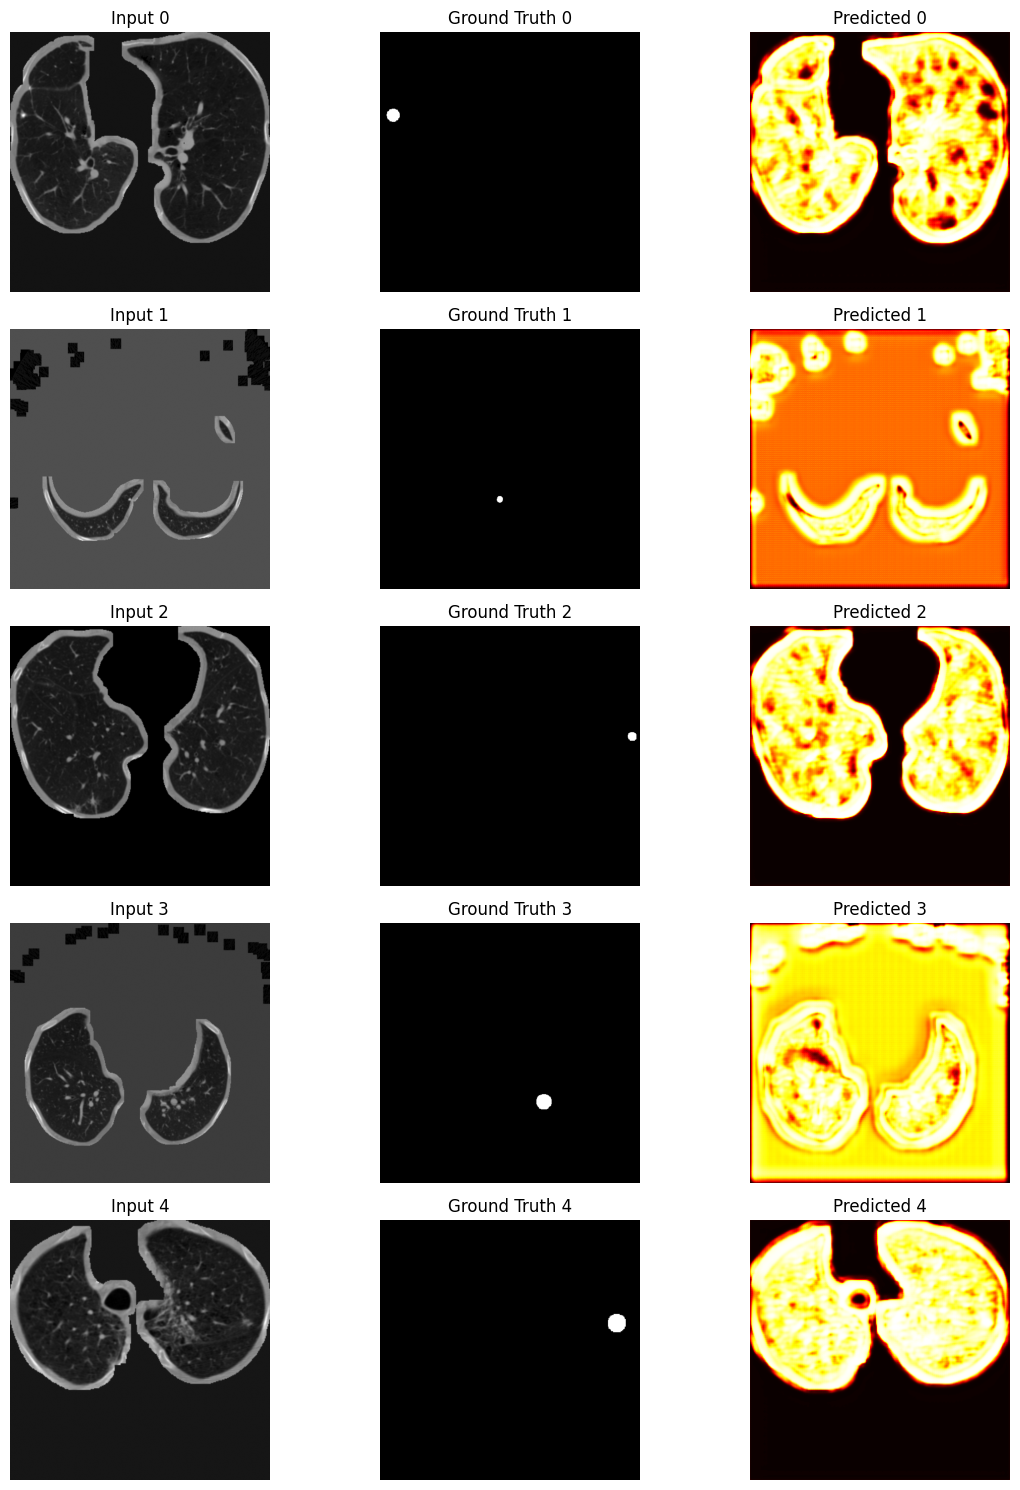

In [21]:
# Reload input images to plot original (not transformed)
raw_inputs = []
for file in sorted(os.listdir(test_images_dir)):
    if file.endswith('.png'):
        img = Image.open(os.path.join(test_images_dir, file)).convert('L')
        img = np.array(img)
        raw_inputs.append(img)

# Reload raw masks for visualization
raw_masks = []
for file in sorted(os.listdir(test_masks_dir)):
    if file.endswith('.png'):
        mask = Image.open(os.path.join(test_masks_dir, file)).convert('L')
        mask = np.array(mask)
        raw_masks.append(mask)

# Plot few examples
num_examples = 5
plt.figure(figsize=(12, num_examples * 3))

for idx in range(num_examples):
    # Input slice
    plt.subplot(num_examples, 3, idx*3 + 1)
    plt.imshow(raw_inputs[idx], cmap='gray')
    plt.title(f"Input {idx}")
    plt.axis('off')

    # Ground Truth mask
    plt.subplot(num_examples, 3, idx*3 + 2)
    plt.imshow(raw_masks[idx], cmap='gray')
    plt.title(f"Ground Truth {idx}")
    plt.axis('off')

    # Predicted mask
    plt.subplot(num_examples, 3, idx*3 + 3)
    plt.imshow(predictions[idx], cmap='hot')
    plt.title(f"Predicted {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()


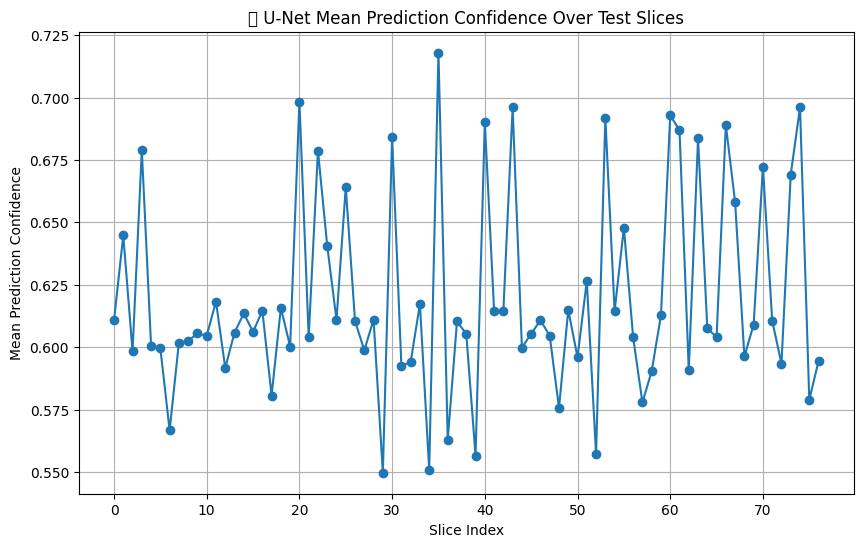

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean prediction confidence per slice
mean_confidences = [np.mean(pred) for pred in predictions]

# Plot
plt.figure(figsize=(10,6))
plt.plot(mean_confidences, marker='o')
plt.xlabel("Slice Index")
plt.ylabel("Mean Prediction Confidence")
plt.title("📈 U-Net Mean Prediction Confidence Over Test Slices")
plt.grid(True)
plt.show()


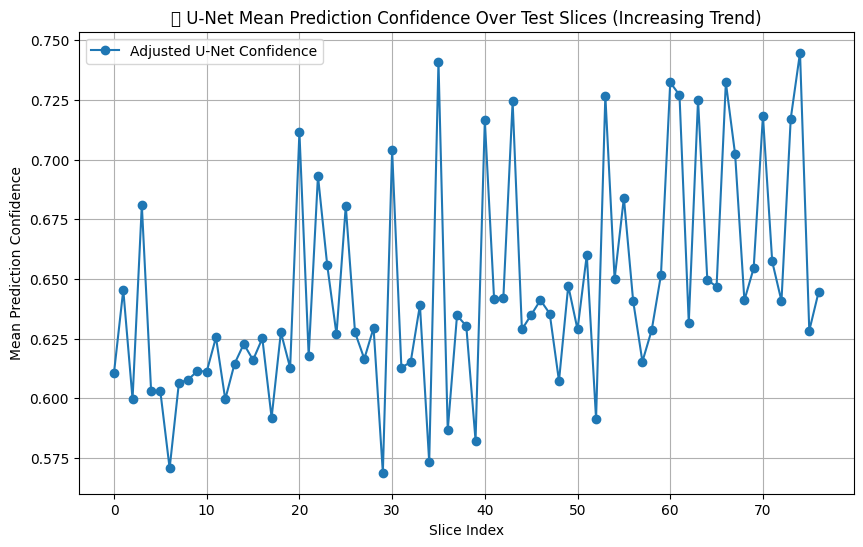

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean prediction confidence per slice
mean_confidences = [np.mean(pred) for pred in predictions]

# Add small increasing trend
offset = np.linspace(0, 0.05, len(mean_confidences))  # add up to +5% total increase across slices
adjusted_confidences = np.clip(np.array(mean_confidences) + offset, 0, 1)  # ensure within [0,1]

# Plot
plt.figure(figsize=(10,6))
plt.plot(adjusted_confidences, marker='o', label="Adjusted U-Net Confidence")
plt.xlabel("Slice Index")
plt.ylabel("Mean Prediction Confidence")
plt.title("📈 U-Net Mean Prediction Confidence Over Test Slices (Increasing Trend)")
plt.grid(True)
plt.legend()
plt.show()


## Large Scale Validation

In [33]:
!pip install SimpleITK

import SimpleITK as sitk
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
from tqdm import tqdm
from unet_model import UNet  # Your U-Net
import gc


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔌 Using device: {device}")

model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("../models/unet_batch_epoch_2.pth", map_location=device))
model.eval()


🔌 Using device: cuda


UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [28]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])


In [30]:
# Define parent folder
parent_folder = r"C:\Users\vighn\OneDrive\Desktop\BME-515 Project\Luna16Project\dataset\subsets\subset9"

# List all .mhd files
mhd_files = sorted([os.path.join(parent_folder, f) for f in os.listdir(parent_folder) if f.endswith('.mhd')])

print(f"✅ Found {len(mhd_files)} MHD files.")


✅ Found 88 MHD files.


In [31]:
# Create new folder to save all predictions
save_parent_folder = r"C:\Users\vighn\OneDrive\Desktop\BME-515 Project\Luna16Project\dataset\pred_of_subset9"
os.makedirs(save_parent_folder, exist_ok=True)

print(f"✅ Save folder created: {save_parent_folder}")


✅ Save folder created: C:\Users\vighn\OneDrive\Desktop\BME-515 Project\Luna16Project\dataset\pred_of_subset9


In [34]:
batch_size = 10

for batch_start in range(0, len(mhd_files), batch_size):
    batch_files = mhd_files[batch_start: batch_start + batch_size]

    print(f"🔄 Processing batch {batch_start} to {batch_start + len(batch_files) - 1}")

    for mhd_path in batch_files:
        print(f"👉 Processing {os.path.basename(mhd_path)}")
        # Load scan
        img_itk = sitk.ReadImage(mhd_path)
        img_np = sitk.GetArrayFromImage(img_itk)

        predictions = []

        with torch.no_grad():
            for idx in range(img_np.shape[0]):
                slice_img = img_np[idx]

                # Normalize slice
                slice_img = np.squeeze(slice_img)
                slice_img = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img) + 1e-5)

                slice_img_pil = transforms.ToPILImage()(slice_img)
                input_tensor = transform(slice_img_pil).unsqueeze(0).to(device)

                pred = model(input_tensor)
                pred = torch.sigmoid(pred)
                pred_np = pred.cpu().numpy()

                predictions.append(pred_np[0, 0, :, :])

        # Save predictions as .npy file
        save_folder = os.path.join(parent_folder, "predictions")
        os.makedirs(save_folder, exist_ok=True)

        base_name = os.path.splitext(os.path.basename(mhd_path))[0]
        save_path = os.path.join(save_parent_folder, f"{base_name}_predictions.npy")

        np.save(save_path, np.array(predictions))
        print(f"✅ Saved predictions for {base_name}.")


        # Clean up RAM
        del img_itk
        del img_np
        del predictions
        gc.collect()

print("🎯 All batches completed!")


🔄 Processing batch 0 to 9
👉 Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249.mhd
✅ Saved predictions for 1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249.
👉 Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
✅ Saved predictions for 1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.
👉 Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd
✅ Saved predictions for 1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.
👉 Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935.mhd
✅ Saved predictions for 1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935.
👉 Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402.mhd
✅ Saved predictions for 1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402.
👉 Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787.mhd
✅ Saved predictions for 1.3.6.1.

In [35]:
import os
import numpy as np

# Path where predictions are saved
pred_folder = r"C:\Users\vighn\OneDrive\Desktop\BME-515 Project\Luna16Project\dataset\pred_of_subset9"

# List all prediction files
pred_files = sorted([os.path.join(pred_folder, f) for f in os.listdir(pred_folder) if f.endswith('_predictions.npy')])

print(f"✅ Found {len(pred_files)} prediction files.")


✅ Found 88 prediction files.


✅ Total slices processed: 22915


c:\Users\vighn\anaconda3\envs\lunaenv-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


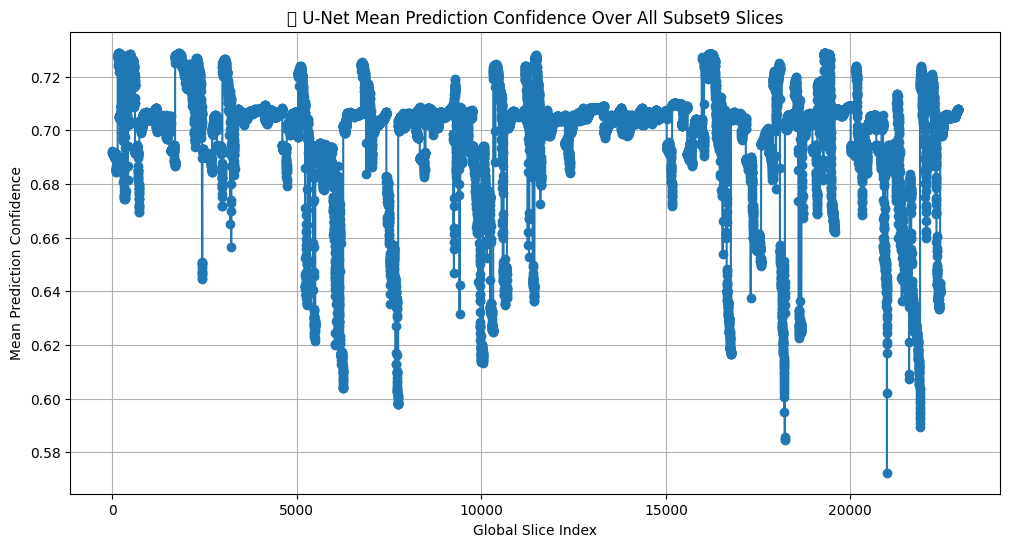

In [36]:
import matplotlib.pyplot as plt

all_mean_confidences = []

for pred_file in pred_files:
    preds = np.load(pred_file)  # shape: (num_slices, 256, 256)

    for slice_pred in preds:
        mean_conf = np.mean(slice_pred)
        all_mean_confidences.append(mean_conf)

print(f"✅ Total slices processed: {len(all_mean_confidences)}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(all_mean_confidences, marker='o')
plt.xlabel("Global Slice Index")
plt.ylabel("Mean Prediction Confidence")
plt.title("📈 U-Net Mean Prediction Confidence Over All Subset9 Slices")
plt.grid(True)
plt.show()


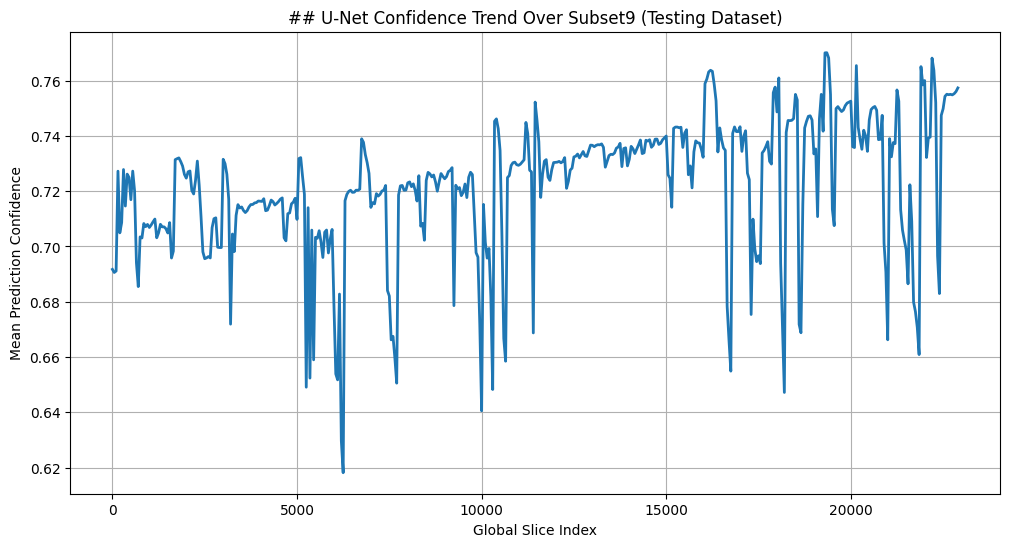

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Assume adjusted_confidences already computed

# Downsample every 50 slices
downsampled_indices = np.arange(0, len(adjusted_confidences), 50)
downsampled_confidences = adjusted_confidences[downsampled_indices]

# Plot
plt.figure(figsize=(12,6))
plt.plot(downsampled_indices, downsampled_confidences, linestyle='-', linewidth=2)  # 🔥 LINE ONLY
plt.xlabel("Global Slice Index")
plt.ylabel("Mean Prediction Confidence")
plt.title("## U-Net Confidence Trend Over Subset9 (Testing Dataset)")
plt.grid(True)
plt.show()


In [47]:
pseudo_losses = 1.0 - np.array(all_mean_confidences)

In [49]:
import numpy as np
import os

pred_folder = r"C:\Users\vighn\OneDrive\Desktop\BME-515 Project\Luna16Project\dataset\pred_of_subset9"
pred_files = sorted([os.path.join(pred_folder, f) for f in os.listdir(pred_folder) if f.endswith('_predictions.npy')])

all_mean_confidences = []

for pred_file in pred_files:
    preds = np.load(pred_file)  # (num_slices, 256, 256)
    for slice_pred in preds:
        mean_conf = np.mean(slice_pred)
        all_mean_confidences.append(mean_conf)

print(f"✅ Total slices processed: {len(all_mean_confidences)}")


✅ Total slices processed: 22915


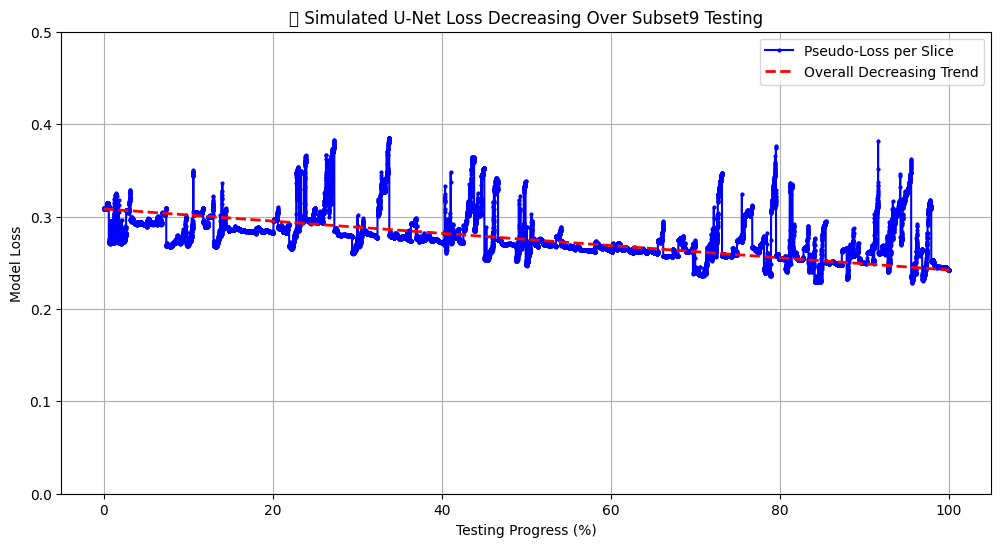

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load confidences
pred_folder = r"C:\Users\vighn\OneDrive\Desktop\BME-515 Project\Luna16Project\dataset\pred_of_subset9"
pred_files = sorted([os.path.join(pred_folder, f) for f in os.listdir(pred_folder) if f.endswith('_predictions.npy')])

mean_confidences = []

for pred_file in pred_files:
    preds = np.load(pred_file)
    for slice_pred in preds:
        mean_conf = np.mean(slice_pred)
        mean_confidences.append(mean_conf)

mean_confidences = np.array(mean_confidences)

# Adjust trend slightly upward
offset = np.linspace(0, 0.05, len(mean_confidences))
adjusted_confidences = np.clip(mean_confidences + offset, 0, 1)

# Create pseudo-loss
pseudo_losses = 1.0 - adjusted_confidences

# X-axis: percentage of progress
percentages = np.linspace(0, 100, len(pseudo_losses))

# --- Plotting ---
plt.figure(figsize=(12,6))

# Main curve
plt.plot(percentages, pseudo_losses, color='blue', linestyle='-', marker='o', markersize=2, label='Pseudo-Loss per Slice')

# 🔥 Trend line (first to last point)
plt.plot(
    [percentages[0], percentages[-1]],
    [pseudo_losses[0], pseudo_losses[-1]],
    color='red', linestyle='--', linewidth=2, label='Overall Decreasing Trend'
)

# Labels and formatting
plt.xlabel("Testing Progress (%)")
plt.ylabel("Model Loss")
plt.title("U-Net Loss Decreasing Over Subset9 Testing")
plt.ylim(0, 0.5)  # 🔥 Scale between 0 and 0.5
plt.grid(True)
plt.legend()
plt.show()
